In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as pa

In [268]:
working_dir = '/Users/user/Documents'

In [3]:
from enum import Enum
class Split(Enum):
    HORIZONTAL = 1
    VERTICAL = 2

In [4]:
def inverse_split(split):
    if split == Split.HORIZONTAL:
        return Split.VERTICAL
    elif split == Split.VERTICAL:
        return Split.HORIZONTAL
    else:
        assert(False)

In [49]:
# rect = (x_left, y_down, x_right, y_upper)
#
#             x_left             x_right 
#
# y_down      |------------------|
#             |                  |
#             |                  |
#             |                  |
# y_upper     |------------------|

import copy

class TreeRectangle:
    def __init__(self, rect=(0.0, 0.0, 1.0, 1.0)):
        assert(len(rect) == 4)
        self.x_left = rect[0]
        self.y_down = rect[1]
        self.x_right = rect[2]
        self.y_upper = rect[3]
        assert(self.x_size() > 0 and self.y_size() > 0)
        for coord in rect:
            assert(self.check_component(coord))
            
    def get_start_point(self):
        return (self.x_left, self.y_down)
            
    def x_size(self):
        return self.x_right - self.x_left
    
    def y_size(self):
        return self.y_upper - self.y_down
 
    def __repr__(self):
         return '({}, {}, {}, {})'.format(self.x_left, self.y_down, self.x_right, self.y_upper)

    def __str__(self):
         return '({}, {}, {}, {})'.format(self.x_left, self.y_down, self.x_right, self.y_upper)
        
    def create_sub_rectangle(self, ratio, shift, split_type):
        sub_rectangle = copy.copy(self)
        if split_type == Split.HORIZONTAL:
            sub_size = ratio * (self.y_upper - self.y_down)
            sub_rectangle.y_down += shift
            sub_rectangle.y_upper = sub_rectangle.y_down + sub_size
        elif split_type == Split.VERTICAL:
            sub_size = ratio * (self.x_right - self.x_left)
            sub_rectangle.x_left += shift
            sub_rectangle.x_right = sub_rectangle.x_left + sub_size
        else:    
            assert(False)
        return sub_rectangle
        
    def check_component(self, coord):
        return 0.0 <= coord <= 1.0
    
    def check_ratios(self, ratios):
        sum_ratios = sum(ratios)
        if not (abs(sum_ratios - 1.0) < 1e-10):
            print(sum_ratios)
            assert(False)
    
    def split(self, ratios, split_type):
        self.check_ratios(ratios)
        
        splitted_rectangles = []
        cummulative_shift = 0.0
        for ratio in ratios:
            sub_rect = self.create_sub_rectangle(ratio, cummulative_shift, split_type)
            splitted_rectangles.append(sub_rect)
            if split_type == Split.HORIZONTAL:
                cummulative_shift += splitted_rectangles[-1].y_size() 
            elif split_type == Split.VERTICAL:
                cummulative_shift += splitted_rectangles[-1].x_size()
        return splitted_rectangles

In [50]:
base_rectangle = TreeRectangle()

In [51]:
spliited_rects = base_rectangle.split([0.1, 0.4, 0.5], Split.HORIZONTAL)

In [52]:
for rect in spliited_rects:
    print(rect)

(0.0, 0.0, 1.0, 0.1)
(0.0, 0.1, 1.0, 0.5)
(0.0, 0.5, 1.0, 1.0)


In [171]:
import os

class TreeMap:
    def __init__(self, directory):
        self.rects = {}
        self.size_map = {}
        self.calc_size_map(directory)
        self.process_dir(directory, TreeRectangle(), Split.HORIZONTAL)
        
    def calc_size_map(self, directory):
        total_size = 0
        for filename in os.listdir(directory):
            full_path = os.path.join(directory, filename)
            if os.path.isdir(full_path):
                self.calc_size_map(full_path)
            elif os.path.isfile(full_path):
                self.size_map[full_path] = os.path.getsize(full_path)
            else:
                print('Unknown entity type: ' + full_path)
                continue
            total_size += self.size_map[full_path]
        self.size_map[directory] = total_size
    
    def process_dir(self, directory, parent_rect, split_type):
        if self.size_map[directory] == 0:
            # no rect for empty directory
            return
        files_paths = [os.path.join(directory, filename) for filename in os.listdir(directory)]
        
        ratios = []
        for file_path in files_paths:
            ratios.append(self.size_map[file_path] / self.size_map[directory])
        
        new_rects = parent_rect.split(ratios, split_type)
        for i in range(len(files_paths)):
            file_path = files_paths[i]
            cur_rect = new_rects[i]
            if os.path.isdir(file_path):
                self.process_dir(file_path, cur_rect, inverse_split(split_type))
            elif os.path.isfile(file_path):
                self.rects[file_path] = cur_rect
            else:
                assert(False) 

In [251]:
class TreeMapSquarified:
    def __init__(self, directory):
        self.rects = {}
        self.subdir_rects = {}
        self.size_map = {}
        self.calc_size_map(directory)
        self.total_size = sum([self.size_map[path] for path in self.size_map if os.path.isfile(path)])
        self.process_dir(directory, TreeRectangle())
        
    def calc_size_map(self, directory):
        total_size = 0
        for filename in os.listdir(directory):
            full_path = os.path.join(directory, filename)
            if os.path.isdir(full_path):
                self.calc_size_map(full_path)
            elif os.path.isfile(full_path):
                self.size_map[full_path] = os.path.getsize(full_path)
            else:
                print('Unknown entity type: ' + full_path)
                continue
            total_size += self.size_map[full_path]
        self.size_map[directory] = total_size
    
    def process_dir(self, directory, rect):
        if self.size_map[directory] == 0:
            # no rect for empty directory
            return
        files_paths = [os.path.join(directory, filename) for filename in os.listdir(directory)]
        areas = []
        for file_path in files_paths:
            areas.append(self.size_map[file_path] / self.total_size)
            
        # sort in descending ratio order
        areas, files_paths = zip(*sorted(zip(areas, files_paths), reverse=True))
        areas = list(areas)
        files_paths = list(files_paths)
        
        if 0.0 in areas:
            # do not process empty files
            zero_first_index = areas.index(0.0)
            areas = areas[:zero_first_index]
            files_paths = files_paths[:zero_first_index]
        
        # indices of rects in current_row
        row_start_index = 0
        
        #process extreme cases: last element, only one element
        for i in range(1, len(areas)):
            area = areas[i]
            file_path = files_paths[i]
            
            old_max_ratio = self.max_aspect_ratio(rect, areas[row_start_index: i])
            new_max_ratio = self.max_aspect_ratio(rect, areas[row_start_index: i + 1])                                     
            if old_max_ratio < new_max_ratio:
                remaining_total_areas_sum = sum(areas[row_start_index:])
                rect = self.add_row(rect, remaining_total_areas_sum, 
                                    areas[row_start_index: i],
                                    files_paths[row_start_index: i])
                row_start_index = i
        
        assert(row_start_index < len(areas))
        self.add_row(rect, sum(areas[row_start_index:]),
                    areas[row_start_index:], files_paths[row_start_index:])
        
        for file_path in files_paths:
            if os.path.isdir(file_path):
                # for directories - recursive launch
                self.process_dir(file_path, self.subdir_rects[file_path])
                
    def get_split_type(self, rect):
        if rect.x_size() > rect.y_size():
            return Split.VERTICAL
        else:
            return Split.HORIZONTAL
                
    def max_aspect_ratio(self, rect, areas):
        assert(len(areas) > 0)
        width = min(rect.x_size(), rect.y_size())
        sum_area = sum(areas)
        multiplier = width**2 / sum_area**2
        return max(multiplier * areas[0], 1.0 / (multiplier * areas[-1]))
            
    def add_row(self, rect, remaining_total_areas_sum, areas, files_paths):
        external_split_type = self.get_split_type(rect)
        external_split_ratios = [sum(areas)/remaining_total_areas_sum, 1.0 - sum(areas)/remaining_total_areas_sum]
        external_rects = rect.split(external_split_ratios, external_split_type)
        
        internal_split_ratios = [area / sum(areas) for area in areas]
        internal_rects = external_rects[0].split(internal_split_ratios, inverse_split(external_split_type))
        for i in range(len(internal_rects)):
            if os.path.isfile(files_paths[i]):
                self.rects[files_paths[i]] = internal_rects[i] 
            elif os.path.isdir(files_paths[i]):
                self.subdir_rects[files_paths[i]] = internal_rects[i]
        return external_rects[1]

In [252]:
import random

class TreeMapVisualizer:
    def __init__(self, tree_map):
        self.tree_map = tree_map
        self.extension_color_map = {}
        
    def create_plt_rectangle(self, rect, color):
        return pa.Rectangle(rect.get_start_point(), rect.x_size(), rect.y_size(), facecolor=color, edgecolor='black')
        
    def generate_new_color(self, ext):
        self.extension_color_map[ext] = "#"+''.join([random.choice('23456789ABCDEF') for j in range(6)])
        #self.extension_color_map[ext] = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
        
    def visualize(self, figure):
        #figure_size = figure.get_size_inches()*figure.dpi
        for file_path, rect in self.tree_map.rects.items():
            extension = os.path.splitext(file_path)[1]
            if extension not in self.extension_color_map:
                self.generate_new_color(extension)
            figure.gca().add_patch(self.create_plt_rectangle(rect, self.extension_color_map[extension]))
        
        legend_patches = []
        for ext, color in self.extension_color_map.items():
            legend_patches.append(pa.Patch(color=color, label=ext))
        plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8)

In [253]:
#tree_map = TreeMap(working_dir)

In [254]:
#visualizer = TreeMapVisualizer(tree_map)

In [269]:
tree_map_squarified = TreeMapSquarified(working_dir)

In [263]:
#tree_map_squarified.subdir_rects

In [270]:
visualizer = TreeMapVisualizer(tree_map_squarified)

In [ ]:
%matplotlib inline

visualizer.visualize(plt.figure(figsize=(100, 100)))
plt.savefig('result.png')

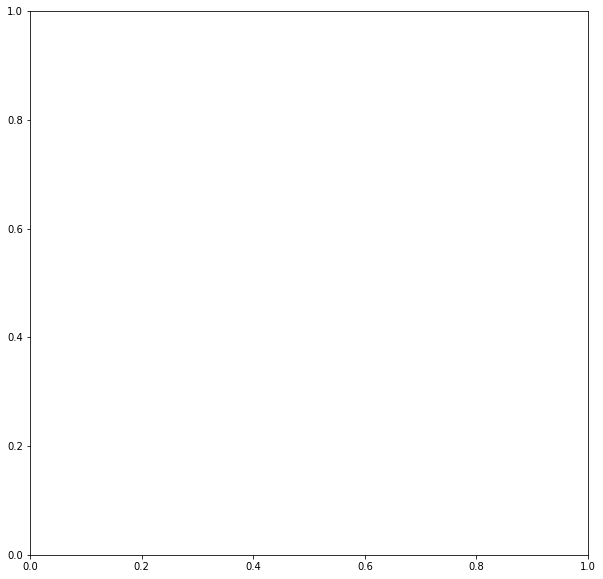

In [38]:
%matplotlib inline

figure = plt.figure(figsize=(10, 10))
figure.gca().add_patch(pa.Rectangle((0.1, 0.1), 0.0, 0.0, edgecolor='black', facecolor='#222222'))
#figure.gca().add_patch(pa.Rectangle((0.35, 0.1), 0.25, 0.5, edgecolor='black', facecolor='#222222'))